In [25]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

drill_costs = pd.read_excel("Analysis_Data.xlsx", header=2, sheet_name="Drilling Cost")

drill_costs.head(10)

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
0,1960-06-30,52.2,102.7,44.0,.,.,.
1,1961-06-30,51.3,94.7,45.2,-0.017241,-0.077897,0.027273
2,1962-06-30,54.2,97.1,50.8,0.05653,0.025343,0.123894
3,1963-06-30,51.8,92.4,48.2,-0.04428,-0.048404,-0.051181
4,1964-06-30,50.6,104.8,48.5,-0.023166,0.134199,0.006224
5,1965-06-30,56.6,101.9,53.1,0.118577,-0.027672,0.094845
6,1966-06-30,62.2,133.8,56.9,0.09894,0.313052,0.071563
7,1967-06-30,66.6,141.0,61.5,0.07074,0.053812,0.080844
8,1968-06-30,79.1,148.5,66.2,0.187688,0.053191,0.076423
9,1969-06-30,86.5,154.3,70.2,0.093552,0.039057,0.060423


# Phase 1: Drilling Costs

In [26]:
drill_costs = drill_costs[
    (drill_costs["Date"].dt.year >= 1991) & (drill_costs["Date"].dt.year <= 2006)
]
drill_costs

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
31,1991-06-30,346.9,506.6,441.2,0.077999,0.074899,0.200544
32,1992-06-30,362.3,426.1,357.6,0.044393,-0.158902,-0.189483
33,1993-06-30,356.6,521.2,387.7,-0.015733,0.223187,0.084172
34,1994-06-30,409.5,535.1,491.5,0.148345,0.026669,0.267733
35,1995-06-30,415.8,629.7,481.2,0.015385,0.176789,-0.020956
36,1996-06-30,341.0,616.0,541.0,-0.179894,-0.021756,0.124273
37,1997-06-30,445.6,728.6,655.6,0.306745,0.182792,0.21183
38,1998-06-30,566.0,815.6,973.2,0.270197,0.119407,0.484442
39,1999-06-30,783.0,798.4,1115.5,0.383392,-0.021089,0.146219
40,2000-06-30,593.4,756.9,1075.4,-0.242146,-0.051979,-0.035948


In [27]:
returns = drill_costs.filter(regex="^Arithmetic Return").to_numpy().flatten()
drill_costs["avg_cost"] = drill_costs.filter(regex="^U\.S\.").mean(axis=1)
returns, drill_costs["avg_cost"]

(array([0.07799875699192034, 0.0748992149374072, 0.2005442176870748,
        0.04439319688671097, -0.1589024871693644, -0.18948322756119668,
        -0.015732818106541507, 0.22318704529453184, 0.08417225950782987,
        0.14834548513740878, 0.026669224865694504, 0.26773278307970083,
        0.015384615384615413, 0.17678938516165207, -0.02095625635808751,
        -0.1798941798941799, -0.02175639193266642, 0.12427265170407317,
        0.3067448680351907, 0.18279220779220784, 0.21182994454713497,
        0.2701974865350089, 0.11940708207521274, 0.4844417327638804,
        0.3833922261484099, -0.021088769004413983, 0.14621866009042328,
        -0.24214559386973183, -0.05197895791583167, -0.03594800537875384,
        0.22868217054263573, 0.1844365173734972, 0.5067881718430352,
        0.21080784528871202, 0.10641383156720577, 0.03270797333991607,
        0.17501132759401905, 0.11503175723359212, 0.2340743396677422,
        0.38995469006073463, 0.5518987341772152, -0.042516100915209895,
  

In [28]:
rng = np.random.default_rng(1234)
kernel = gaussian_kde(returns)

initial_cost = drill_costs["avg_cost"].iloc[-1]

mean_return = returns.mean()
std_return = returns.std()

years_1 = 2012 - 2006
years_2 = 2015 - 2012
years_3 = 2024 - 2015

kernel.factor

0.4610539557408639

In [29]:
norm_data = []

for i in range(100000):
    normal_return = rng.normal(mean_return, std_return, years_1)

    phase_2 = rng.triangular(left=-0.22, mode=-0.0917, right=-0.07, size=years_2)
    phase_3 = rng.triangular(left=0.02, mode=0.05, right=0.06, size=years_3)

    normal_phases = np.concatenate((normal_return, phase_2, phase_3))

    normal_future_vals = initial_cost * np.cumprod(1 + normal_phases)
    norm_data.append(normal_future_vals[-1])

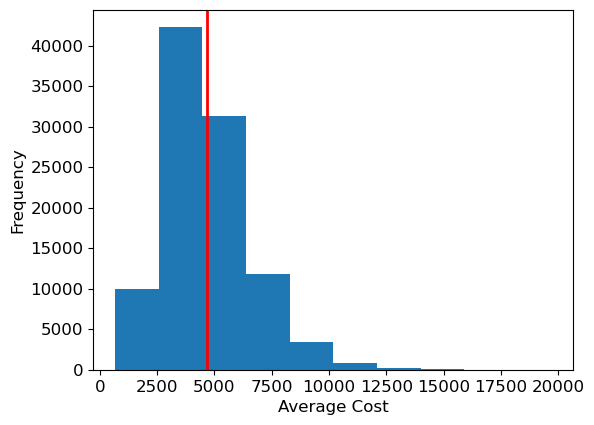

In [30]:
plt.rcParams.update({"font.size": 12})
plt.hist(norm_data)
plt.axvline(x=np.mean(norm_data), color="r", linestyle="-", linewidth=2)
plt.xlabel("Average Cost")
plt.ylabel("Frequency")
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()